Concept: 
- PER calcuation based on the last n years of op income, EBITDA and net income for a group of companies in a sector
    - Company value = current value + growth value
    - Capacity of income (cash) generation = normalization of incomes over a cycle of business
- One effort is to estimate the current value based on the capacity of income generation of a company, using data from the last n years of op income, EBITDA and net income 

Challenge:
- if the final result is only price / EPS (somehow calculated, a scaler) for a group of companies, then it only contains (almost) the same information as the price itself.
- group of companies must be meaningful to compare to each other

Outcome: 
- 241560
    - Bobcat, could be a good company with extremely low PER / however, historically it's PER performance is not so high. Will it be increasing anyway?
    - Is it due to slow down of construction industry? In NA, it seems OK. In the recent years, the industry was at high.


In [1]:
import FinanceDataReader as fdr
import pandas as pd
import OpenDartReader 
import json

In [ ]:
# df_krx preparation

def generate_krx_data(): 
    df_krx_desc = fdr.StockListing('KRX-DESC')
    df_krx = fdr.StockListing('KRX')

    df_krx.drop(columns=['Close', 'ChangeCode', 'Changes', 'ChagesRatio', 'Open', 'High', 'Low', 'Volume', 'Amount'], inplace=True)
    cols_to_use = df_krx_desc.columns.difference(df_krx.columns).tolist()
    cols_to_use.append('Code')
    df_krx = df_krx.merge(df_krx_desc[cols_to_use], on='Code', how='left')
    df_krx = df_krx.set_index('Code')

    df_krx=df_krx[~df_krx['Dept'].str.contains('관리')]   # remove companies in trouble
    df_krx.to_feather('data/df_krx.feather')

    return None

# generate_krx_data()

In [60]:
# post process of df_krx

MARCAP_THRESHOLD = 3000*10**8 
IPO_YEAR_THRESHOLD = 3 
SECTOR_TARGET = '특수 목적용 기계 제조업'

df_krx = pd.read_feather('data/df_krx.feather')

df_krx = df_krx.loc[df_krx['Marcap'] >= MARCAP_THRESHOLD]
df_krx = df_krx.loc[pd.Timestamp.today()- df_krx['ListingDate'] > pd.Timedelta(days = IPO_YEAR_THRESHOLD*(365+1))]

sectors_count = df_krx.reset_index()[['Code', 'Sector']].dropna().groupby('Sector').count().sort_values('Code', ascending=False)
sector = df_krx.loc[df_krx['Sector']==SECTOR_TARGET]

In [64]:
PRICE_START_DATE = '2013-01-01'

def generate_sector_prices(sector):
    sector_prices = pd.DataFrame()
    for code in sector.index:
        sector_prices = pd.concat([sector_prices, fdr.DataReader(code, PRICE_START_DATE)['Close'].rename(code, inplace=True)], axis=1)
    sector_prices = sector_prices.sort_index() 
    sector_prices.to_feather('data/sector_prices.feather')

    return None

# generate_sector_prices(sector)

In [65]:
sector_prices = pd.read_feather('data/sector_prices.feather')

In [67]:
with open('../../config/config.json', 'r') as json_file:
    config = json.load(json_file)
    dart_api = config['dart_api']

dart = OpenDartReader(dart_api)

In [ ]:
import datetime

def generate_yearly_opincome(sector):
    current_year = datetime.datetime.now().year
    yearly_opincome = []
    for code in sector.index.values:
        record = {'code': code}
        listed_year = sector.loc[sector.index==code]['ListingDate'].iloc[0].year
        if listed_year < 2015:  # Dart only serves since 2015 annual report 
            listed_year = 2015
        elif listed_year == current_year: 
            continue
        rec = dart.finstate(code, bsns_year=listed_year)
        if len(rec) > 0: 
            try:
                record[listed_year-2] = int(rec.loc[rec['account_nm']=='영업이익'].iloc[0,:]['bfefrmtrm_amount'].replace(',',''))
                record[listed_year-1] = int(rec.loc[rec['account_nm']=='영업이익'].iloc[0,:]['frmtrm_amount'].replace(',',''))
                record[listed_year] = int(rec.loc[rec['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))
            except: 
                pass
        for yr in range(listed_year+1, 2023):
            rec = dart.finstate(code, bsns_year=yr)
            if len(rec) > 0:
                try:
                    opincome = int(rec.loc[rec['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   # CFS/OFS (if Consolidated exists consolidated op income, otherwise standalone op income)
                    record[yr] = opincome
                except:
                    pass
        yearly_opincome.append(record)
    yearly_opincome = pd.DataFrame(yearly_opincome).set_index('code')
    yearly_opincome.to_feather('data/yearly_opincome.feather')
    
    return None

# generate_yearly_opincome(sector)

In [ ]:
yearly_opincome = pd.read_feather('data/yearly_opincome.feather')
# yearly_opincome.T.sort_index().plot(figsize=(30,20))

In [ ]:
def generate_quarterly_opincome(sector):
    # 1분기보고서 : 11013
    # 반기보고서 : 11012
    # 3분기보고서 : 11014
    # 사업보고서 : 11011

    start_year = 2016 # one year after DART service year 
    current_year = datetime.datetime.now().year
    quarterly_opincome = []

    for code in sector.index.values:
        record = {'code': code}
        for yr in range(start_year, current_year):
            try:
                rec_1q = dart.finstate(code, yr, reprt_code='11013')
                rec_2q = dart.finstate(code, yr, reprt_code='11012')
                rec_3q = dart.finstate(code, yr, reprt_code='11014')
                rec = dart.finstate(code, yr, reprt_code='11011')

                opincome_1q = int(rec_1q.loc[rec_1q['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   
                opincome_2q = int(rec_2q.loc[rec_2q['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   
                opincome_3q = int(rec_3q.loc[rec_3q['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   
                opincome_4q = int(rec.loc[rec['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',','')) - (opincome_1q + opincome_2q + opincome_3q)

                record[str(yr)+'_1q'] = opincome_1q
                record[str(yr)+'_2q'] = opincome_2q
                record[str(yr)+'_3q'] = opincome_3q
                record[str(yr)+'_4q'] = opincome_4q
            except:
                pass
        try:
            rec_1q = dart.finstate(code, current_year, reprt_code='11013')
            rec_2q = dart.finstate(code, current_year, reprt_code='11012')
            rec_3q = dart.finstate(code, current_year, reprt_code='11014')
            opincome_1q = int(rec_1q.loc[rec_1q['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   
            record[str(current_year)+'_1q'] = opincome_1q
            opincome_2q = int(rec_2q.loc[rec_2q['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   
            record[str(current_year)+'_2q'] = opincome_2q
            opincome_3q = int(rec_3q.loc[rec_3q['account_nm']=='영업이익'].iloc[0,:]['thstrm_amount'].replace(',',''))   
            record[str(current_year)+'_3q'] = opincome_3q
        except:
            pass
        quarterly_opincome.append(record)

    quarterly_opincome = pd.DataFrame(quarterly_opincome).set_index('code')
    quarterly_opincome.to_feather('data/quarterly_opincome.feather')

    return None

generate_quarterly_opincome(sector)

In [143]:
quarterly_opincome = pd.read_feather('data/quarterly_opincome.feather')
display(quarterly_opincome)
desc_qo = quarterly_opincome.T.describe()
display(desc_qo)

,2017_1q,2017_2q,2017_3q,2017_4q,2018_1q,2018_2q,2018_3q,2018_4q,2019_1q,2019_2q,...,2022_1q,2022_2q,2022_3q,2022_4q,2023_1q,2023_2q,2016_1q,2016_2q,2016_3q,2016_4q
code,,,,,,,,,,,,,,,,,,,,,
241560,9.328703e+10,1.359746e+11,1.016308e+11,6.362324e+10,9.432235e+10,1.388672e+11,1.228774e+11,1.029830e+11,1.133003e+11,1.571227e+11,...,194384702000,309512444000,316866619000,250843009000,369675374000,466549461000,NaN,NaN,NaN,NaN
042700,6.813345e+09,1.881446e+10,1.456035e+10,1.146701e+10,1.072463e+10,2.484287e+10,1.523122e+10,5.990201e+09,2.389999e+08,-1.648914e+09,...,21258352012,43888676639,32195531281,14516862148,2074898916,11176246626,1.590741e+10,9.643040e+09,7.443937e+09,5.560069e+09
042670,1.483547e+11,2.147035e+11,1.439319e+11,1.537792e+11,2.415739e+11,2.730663e+11,1.914911e+11,1.419961e+11,2.500433e+11,2.971729e+11,...,104858322416,86632442853,74687258657,66368860339,152605604266,162008555787,1.112034e+11,1.734902e+11,1.057789e+11,1.003457e+11
039030,1.480537e+10,1.635231e+10,1.812302e+10,1.069842e+10,5.241657e+09,1.555186e+10,9.211425e+08,-3.855730e+09,1.037683e+09,5.341695e+09,...,22483637362,30990932308,23528330413,15795780803,9593216741,10943715847,5.232101e+09,2.814584e+08,8.024472e+09,7.720704e+09
240810,3.229190e+10,4.687129e+10,3.023757e+10,1.285100e+10,2.205723e+10,4.603234e+10,4.637401e+10,-8.569060e+09,6.389081e+09,3.422818e+10,...,22036736303,18521242404,30457298850,26539599031,-10729505934,-18246132849,NaN,NaN,NaN,NaN
137400,3.273342e+09,2.032297e+09,2.686469e+09,2.280008e+09,5.369490e+09,-2.970637e+09,3.418643e+09,-2.063306e+09,2.728792e+09,5.591668e+09,...,12606214418,22518841767,17640204389,24999904739,17313570539,16353390122,1.837215e+09,1.840650e+09,1.964044e+09,1.831122e+09
036930,1.260073e+10,1.298379e+10,8.713804e+09,7.392399e+09,1.271244e+10,6.962715e+09,7.475670e+09,1.424113e+10,9.603384e+09,9.822959e+09,...,30595275868,34625504231,30644998062,28018222381,11592542813,-8735134050,8.000267e+09,9.314437e+09,8.287870e+09,1.208592e+10
056190,4.437273e+10,7.813672e+10,6.260218e+10,5.097622e+10,5.135620e+10,6.062734e+10,5.693582e+10,6.543790e+10,4.055797e+10,4.869488e+10,...,50513661057,41756582807,46397608832,22252489496,25792823979,21361756662,4.762495e+09,1.960193e+10,2.955743e+10,6.688727e+10
084370,1.018840e+10,3.246815e+09,6.393546e+08,1.165096e+10,2.238211e+10,1.050594e+10,6.017383e+09,1.897812e+09,6.162513e+09,1.601037e+10,...,32464218180,6027636389,13615918577,1533181221,9742033338,8541422792,1.490344e+10,1.161401e+10,8.509608e+09,1.423999e+09


code,241560,042700,042670,039030,240810,137400,036930,056190,084370,098460,...,000490,095610,039440,064290,089970,282880,297890,079370,108490,232140
count,2.600000e+01,3.000000e+01,3.000000e+01,3.000000e+01,2.600000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,...,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,1.800000e+01,1.400000e+01,1.000000e+01,3.000000e+01,1.800000e+01,2.600000e+01
mean,1.626006e+11,1.583011e+10,1.470126e+11,1.120514e+10,2.471415e+10,8.137260e+09,1.186785e+10,4.566021e+10,9.830555e+09,9.016705e+09,...,8.560228e+09,1.087007e+10,6.361216e+09,1.262562e+09,7.138609e+09,2.992179e+09,3.620828e+09,6.833896e+09,-3.565577e+08,6.108356e+09
std,9.983434e+10,1.136452e+10,8.891048e+10,9.531686e+09,3.576133e+10,8.881929e+09,1.346815e+10,1.728395e+10,8.824601e+09,3.107286e+09,...,1.607316e+10,8.732097e+09,3.324452e+09,3.813493e+09,8.063167e+09,3.684444e+09,4.982790e+09,5.559222e+09,6.955456e+08,6.191528e+09
min,6.362324e+10,-1.648914e+09,-1.737093e+11,-3.855730e+09,-4.360480e+10,-1.295198e+10,-1.381280e+10,4.762495e+09,-8.733693e+08,2.017580e+09,...,-1.924488e+10,-3.752437e+09,1.147197e+09,-4.515864e+09,-4.338065e+09,-5.965010e+08,-1.872163e+09,-7.705748e+09,-1.693456e+09,-3.991577e+09
25%,1.019689e+11,7.441829e+09,1.066229e+11,5.234490e+09,7.125600e+09,2.094225e+09,7.413216e+09,3.493977e+10,2.697536e+09,7.041254e+09,...,-3.852263e+09,5.986612e+09,3.469523e+09,-1.112616e+09,2.115758e+09,4.960112e+08,1.295054e+09,4.231900e+09,-6.582141e+08,2.518612e+09
50%,1.305813e+11,1.439817e+10,1.504802e+11,1.014582e+10,2.315642e+10,5.850481e+09,9.890769e+09,4.604430e+10,8.525516e+09,9.704429e+09,...,7.541419e+09,9.276197e+09,6.155157e+09,9.289303e+08,5.989050e+09,1.904955e+09,3.167447e+09,6.746163e+09,-3.944339e+08,5.933880e+09
75%,1.677409e+11,2.095888e+10,1.797936e+11,1.621318e+10,4.308130e+10,1.466500e+10,1.392679e+10,5.554091e+10,1.312468e+10,1.148279e+10,...,2.025180e+10,1.499049e+10,8.463666e+09,2.981881e+09,1.095109e+10,4.650127e+09,4.019541e+09,9.024155e+09,-5.032113e+06,9.132142e+09
max,4.665495e+11,4.388868e+10,2.971729e+11,3.124124e+10,1.184717e+11,2.499990e+10,5.072636e+10,7.926148e+10,3.246422e+10,1.393084e+10,...,4.613251e+10,3.303337e+10,1.397409e+10,1.374742e+10,2.709457e+10,1.263043e+10,1.649205e+10,2.305576e+10,7.248393e+08,1.861954e+10


In [207]:
# quarterly_opincome.T.sort_index().plot(figsize=(30,20))
# print(desc_qo.idxmin(axis=1))
# display(desc_qo.loc[['std','min']].sort_values(by=['std'], axis=1))
# display(desc_qo.T.loc[desc_qo.loc['25%']>0].sort_values('std'))


# Condition: at least 25% quartile of op incomes has to be positive
companies_to_analyze = desc_qo.T.loc[desc_qo.loc['25%']>0].index
quarterly_opincome_to_analyze = quarterly_opincome.loc[companies_to_analyze.values].T.sort_index()   
# display(quarterly_opincome_to_analyze)

# adj opincome period = last n quarters; yearly avarege
ADJ_OPINCOME_DURATION = IPO_YEAR_THRESHOLD - 1
EPS_to_analyze = pd.DataFrame(quarterly_opincome_to_analyze[-(ADJ_OPINCOME_DURATION*4):].sum()/ADJ_OPINCOME_DURATION, columns=['adj_opincome'])
EPS_to_analyze = EPS_to_analyze.merge(df_krx['Stocks'], how='left', left_index=True, right_index=True).rename(columns={'Stocks':'nm_shares'})
EPS_to_analyze['adj_EPS'] = (EPS_to_analyze['adj_opincome']/EPS_to_analyze['nm_shares']).round(3)

display(EPS_to_analyze)

,adj_opincome,nm_shares,adj_EPS
code,,,
241560,1.095905e+12,100249166,10931.809
042700,9.588174e+10,97339302,985.026
042670,2.535690e+11,199603453,1270.364
039030,7.294590e+10,12319550,5921.150
240810,5.385146e+10,49083901,1097.131
137400,6.993820e+10,22741198,3075.396
036930,1.006233e+11,48249212,2085.490
056190,1.607986e+11,35908760,4477.976
084370,5.441855e+10,22916042,2374.692


In [215]:
PER_to_analyze = sector_prices[EPS_to_analyze.index].loc[sector_prices.index > pd.Timestamp.today()- pd.Timedelta(days = IPO_YEAR_THRESHOLD*(365+1))]/EPS_to_analyze['adj_EPS']


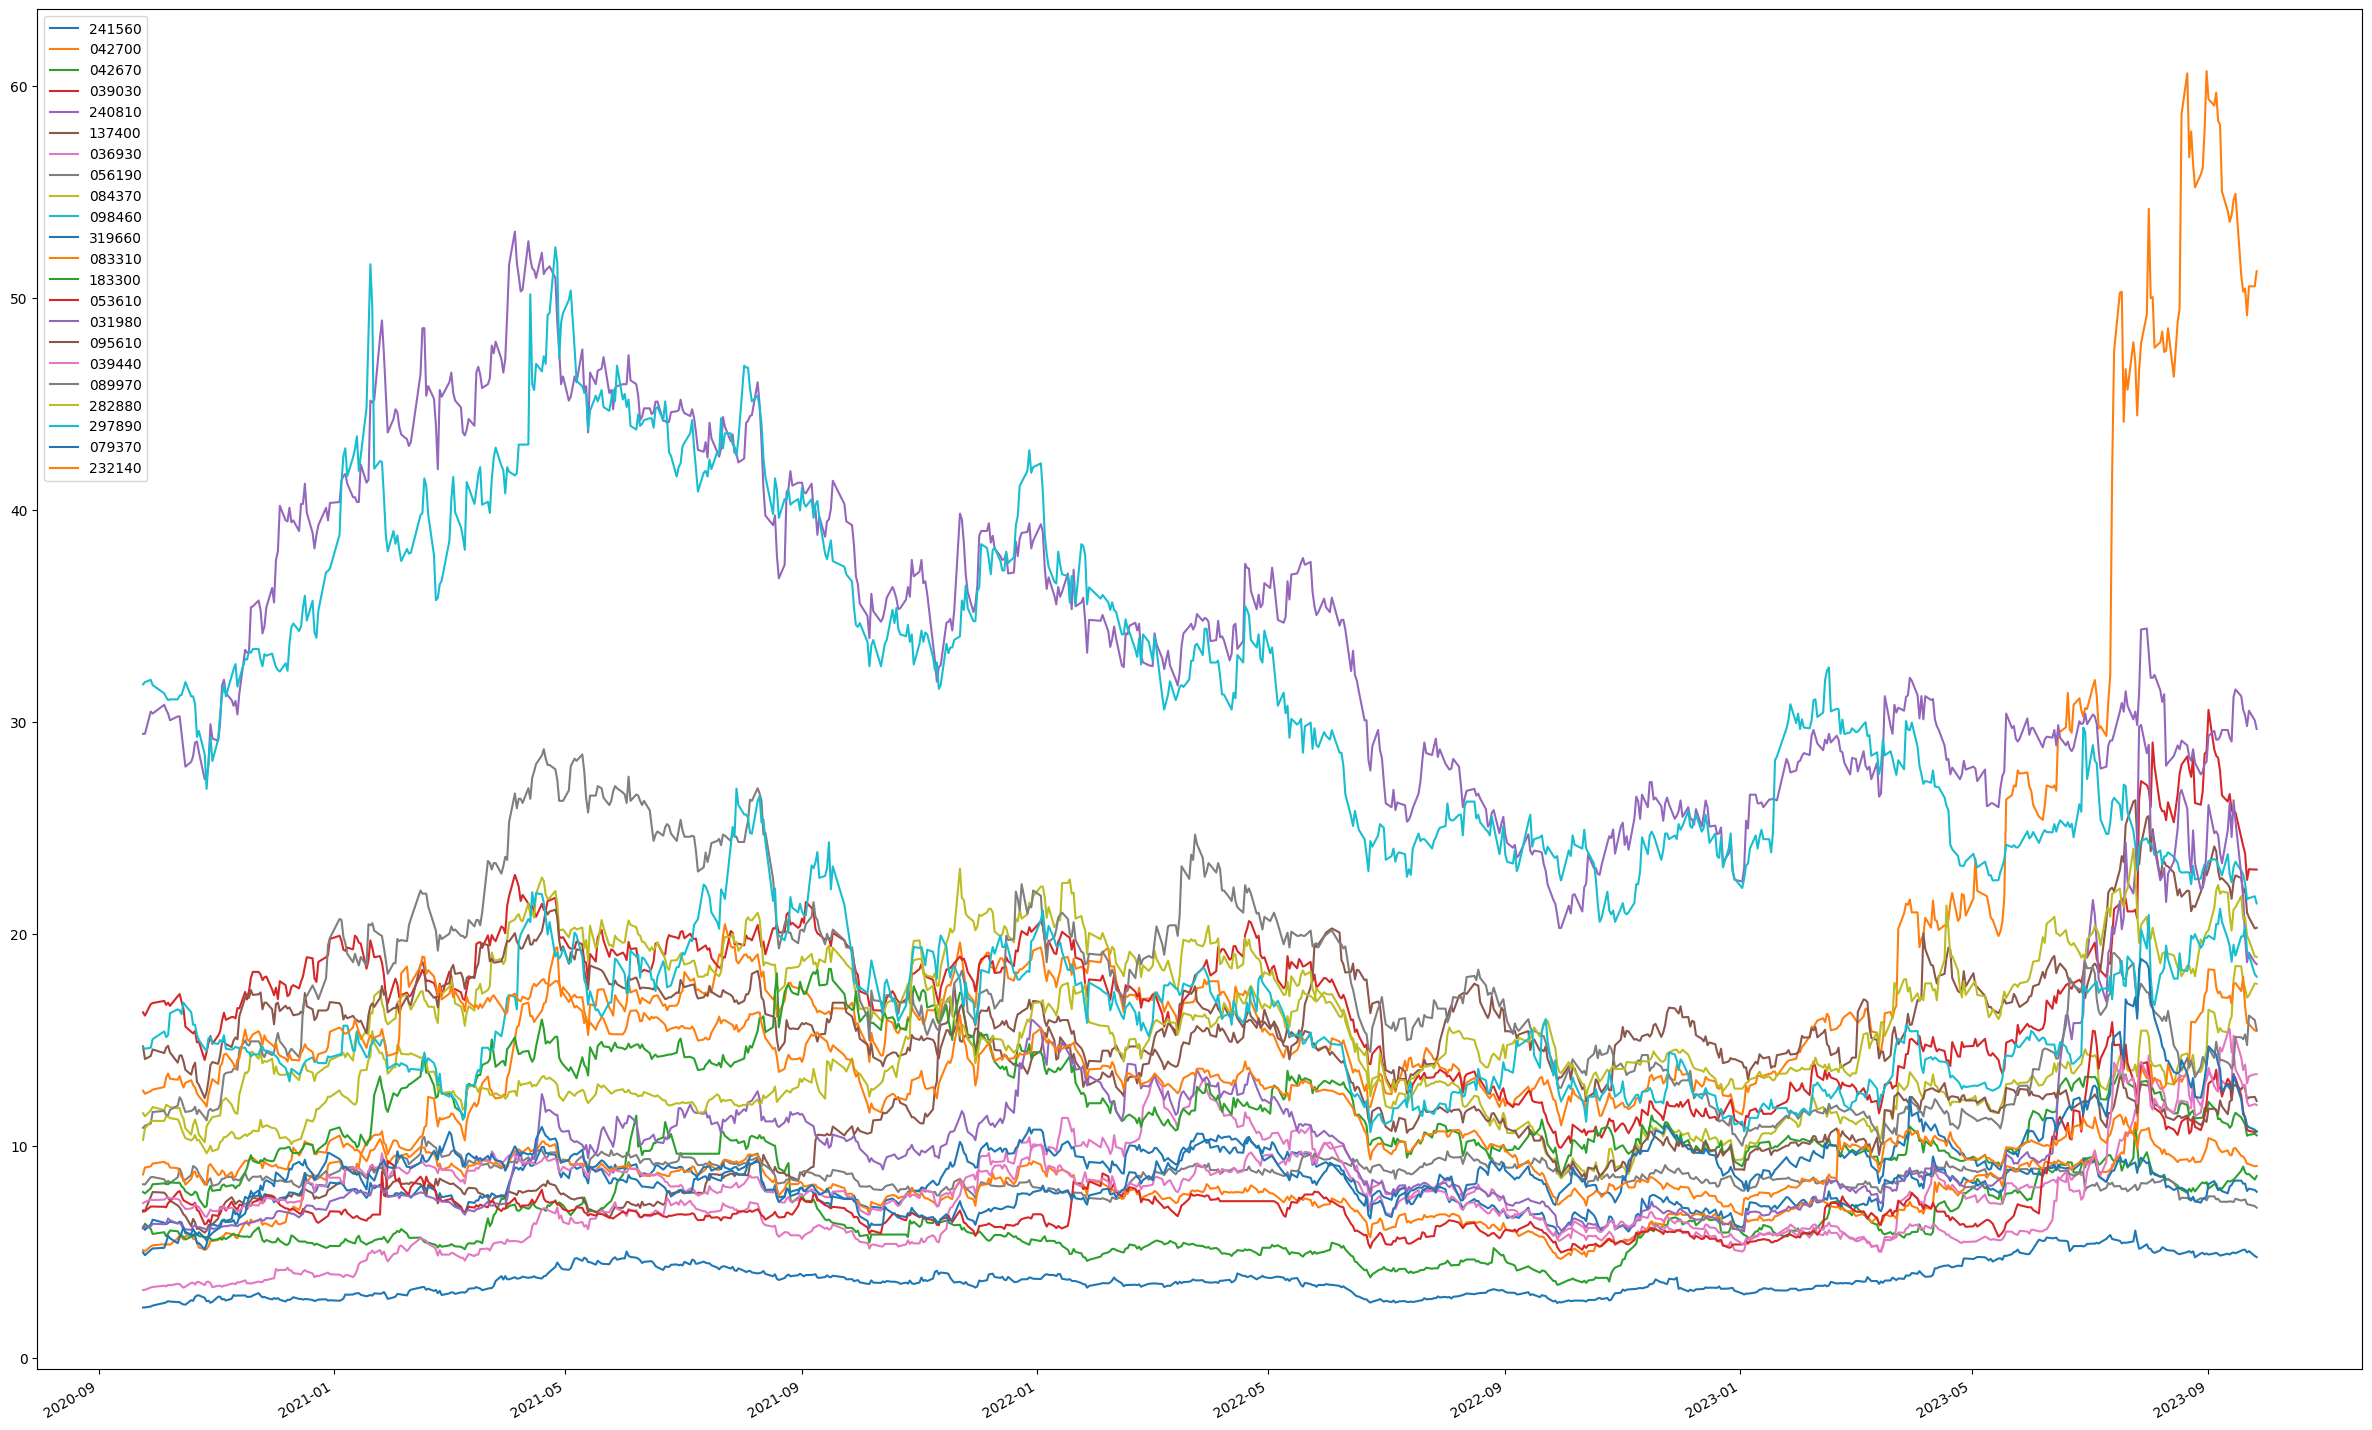

In [218]:
PER_to_analyze.plot(figsize=(30,20))
PER_to_analyze.to_feather('data/PER_to_analyze.feather')